In [1]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [3]:
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


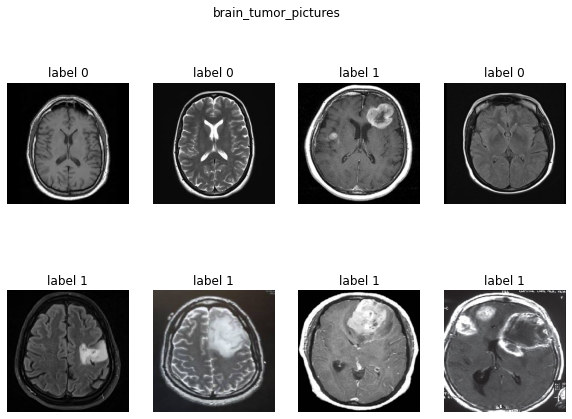

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - 18s 3s/step - loss: 9.2659 - acc: 0.5369 - val_loss: 10.7858 - val_acc: 0.6200

Epoch 00001: acc improved from -inf to 0.53695, saving model to model/vgg19_best.h5
Epoch 2/25
4/4 [==============================] - 2s 368ms/step - loss: 4.9680 - acc: 0.7438 - val_loss: 5.2830 - val_acc: 0.4200

Epoch 00002: acc improved from 0.53695 to 0.74384, saving model to model/vgg19_best.h5
Epoch 3/25
4/4 [==============================] - 1s 341ms/step - loss: 4.7501 - acc: 0.5074 - val_loss: 3.8705 - val_acc: 0.7600

Epoch 00003: acc did not improve from 0.74384
Epoch 4/25
4/4 [==============================] - 2s 400ms/step - loss: 3.6783 - acc: 0.7488 - val_loss: 3.6641 - val_acc: 0.7600

Epoch 00004: acc improved from 0.74384 to 0.74877, saving model to model/vgg19_best.h5
Epoch 5/25
4/4 [==============================] - 1s 353ms/step - loss: 1.3356 - acc: 0.8473 - val_loss: 3.6481 - val_acc: 0.6800

Epoch 00005: acc improved from 0.74877 to 

In [7]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 0s 346ms/step - loss: 1.0122 - acc: 0.8200


,Train,Val
Loss,0.020400,1.012185
Acc,0.990148,0.820000


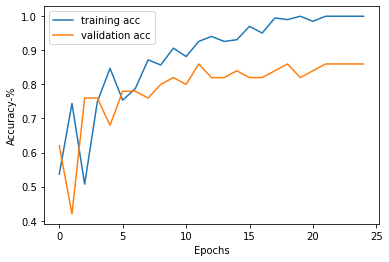

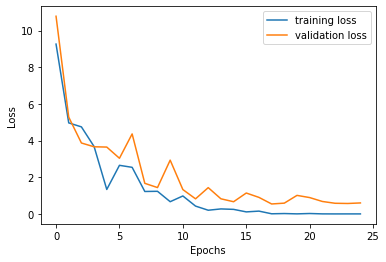

In [8]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [9]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - 9s 2s/step - loss: 0.5557 - acc: 0.8300 - val_loss: 0.8181 - val_acc: 0.8400

Epoch 00001: acc did not improve from 1.00000
Epoch 2/25
4/4 [==============================] - 5s 1s/step - loss: 0.6198 - acc: 0.8379 - val_loss: 0.4114 - val_acc: 0.8600

Epoch 00002: acc did not improve from 1.00000
Epoch 3/25
4/4 [==============================] - 5s 1s/step - loss: 0.5216 - acc: 0.8577 - val_loss: 0.4057 - val_acc: 0.8800

Epoch 00003: acc did not improve from 1.00000
Epoch 4/25
4/4 [==============================] - 5s 1s/step - loss: 0.3756 - acc: 0.8814 - val_loss: 0.2958 - val_acc: 0.9200

Epoch 00004: acc did not improve from 1.00000
Epoch 5/25
4/4 [==============================] - 5s 1s/step - loss: 0.4652 - acc: 0.8656 - val_loss: 0.2151 - val_acc: 0.9200

Epoch 00005: acc did not improve from 1.00000
Epoch 6/25
4/4 [==============================] - 5s 1s/step - loss: 0.3552 - acc: 0.8893 - val_loss: 0.3161 - val_acc: 0.9200

Ep

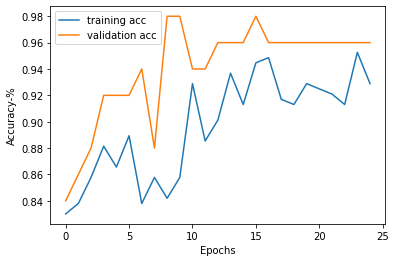

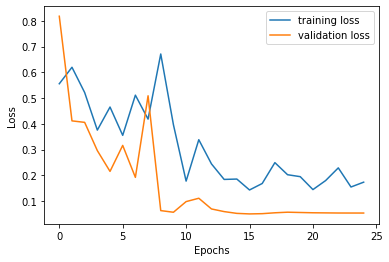

In [11]:
plot_learning_curve(history)

In [12]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 0s 367ms/step - loss: 0.0532 - acc: 0.9600


,Train,Val
Loss,0.002781,0.05324
Acc,1.000000,0.96000


In [13]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

[[17  2]
 [ 0 31]]

               precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.94      0.97        33

    accuracy                           0.96        50
   macro avg       0.95      0.97      0.96        50
weighted avg       0.96      0.96      0.96        50



In [14]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [15]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - 8s 1s/step - loss: 3.7616 - acc: 0.5369 - val_loss: 2.3065 - val_acc: 0.7000

Epoch 00001: acc improved from -inf to 0.53695, saving model to model/inceptionv3_best.h5
Epoch 2/25
4/4 [==============================] - 2s 400ms/step - loss: 2.0507 - acc: 0.7291 - val_loss: 1.7337 - val_acc: 0.8000

Epoch 00002: acc improved from 0.53695 to 0.72906, saving model to model/inceptionv3_best.h5
Epoch 3/25
4/4 [==============================] - 2s 430ms/step - loss: 0.6816 - acc: 0.8916 - val_loss: 1.2003 - val_acc: 0.9000

Epoch 00003: acc improved from 0.72906 to 0.89163, saving model to model/inceptionv3_best.h5
Epoch 4/25
4/4 [==============================] - 2s 408ms/step - loss: 0.6061 - acc: 0.9261 - val_loss: 1.0534 - val_acc: 0.9200

Epoch 00004: acc improved from 0.89163 to 0.92611, saving model to model/inceptionv3_best.h5
Epoch 5/25
4/4 [==============================] - 2s 584ms/step - loss: 0.2123 - acc: 0.9557 - val_loss: 1.424

In [16]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 0s 415ms/step - loss: 1.0885 - acc: 0.9000


,Train,Val
Loss,0.002661,1.088467
Acc,1.000000,0.900000


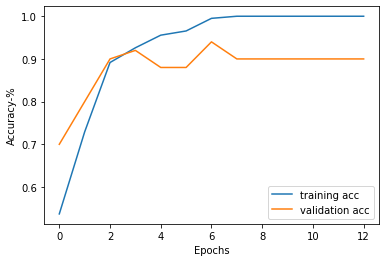

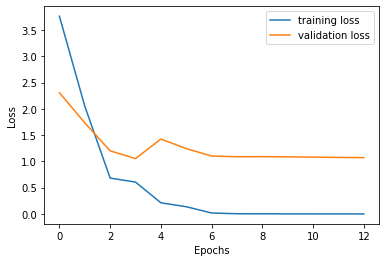

In [17]:
plot_learning_curve(history)

In [18]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/25
4/4 [==============================] - 7s 2s/step - loss: 1.5505 - acc: 0.8498 - val_loss: 3.6701 - val_acc: 0.6600

Epoch 00001: acc did not improve from 1.00000
Epoch 2/25
4/4 [==============================] - 7s 2s/step - loss: 1.4677 - acc: 0.8024 - val_loss: 0.6904 - val_acc: 0.9000

Epoch 00002: acc did not improve from 1.00000
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 1.2962 - acc: 0.8538 - val_loss: 1.8560 - val_acc: 0.7200

Epoch 00003: acc did not improve from 1.00000
Epoch 4/25
4/4 [==============================] - 7s 2s/step - loss: 1.1536 - acc: 0.8379 - val_loss: 0.5906 - val_acc: 0.9200

Epoch 00004: acc did not improve from 1.00000
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 0.7212 - acc: 0.8854 - val_loss: 0.4618 - val_acc: 0.9000

Epoch 00005: acc did not improve from 1.00000
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 0.5558 - acc: 0.8775

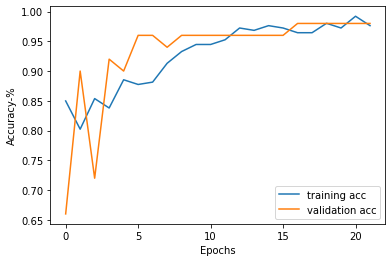

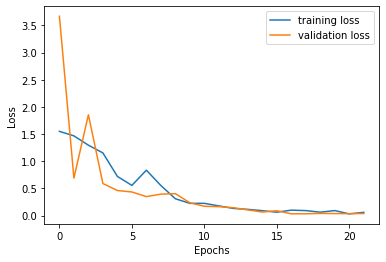

In [19]:
plot_learning_curve(history)

In [20]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

1/1 [==============================] - 0s 433ms/step - loss: 0.0330 - acc: 0.9800


,Train,Val
Loss,0.002465,0.032993
Acc,1.000000,0.980000


In [21]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

Confusion_Matrix:
 [[18  1]
 [ 0 31]]

Classification_report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.97      0.98        32

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

